# Práctica 4


In [13]:
import pandas as pd
import warnings
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
!pip install river
import river

## Exploración de datos

### Cargando los datos y obteniendo información


In [42]:
df = pd.read_csv('sensor.csv')

df.shape
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [39]:

def calc_percent_NAs(df):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]



calc_percent_NAs(df).head(10)

,percent
sensor_15,1.000000
sensor_50,0.349569
sensor_51,0.069821
sensor_00,0.046333
sensor_07,0.024741
sensor_08,0.023180
sensor_06,0.021777
sensor_09,0.020856
sensor_01,0.001675
sensor_30,0.001185


### Limpieza de datos y preprocesamiento antes de realizar el EDA

Se decide eliminar los sensores sin datos y rellenar aquellos que sí que los tienen. 

In [43]:
df = df.drop_duplicates()
df = df.drop(columns='Unnamed: 0')
df = df.drop(columns=['sensor_15'], errors='ignore')
warnings.filterwarnings("ignore")
df['date'] = pd.to_datetime(df['timestamp'])
df = df.drop(columns='timestamp')

In [ ]:
'''
for col in df.columns:
  if col!='machine_status':
    df[col]=df[col].fillna(df[col].mean())
'''

Se manejan los valores faltantes, imputar con la media para este caso

In [44]:
# Esto es una manera de preparar los datos, la otra sería con lo siguiente. Creo que se podrían hacer ambos
numeric_columns = df.select_dtypes(include=[np.number]).columns
for column in numeric_columns:
    df[column].fillna(df[column].mean(), inplace=True)

Se usa a continuación el módulo de preprocesamiento de sklearn para transformar los datos. Utilizamos la lista 'cols' como nombre de las listas a escalar. El escalador Min-Max escala cada característica a un rango dado. Se realiza este escalado porque el análisis de componentes principales o PCA es especialmente sensible a la escala de las características.


In [55]:
from sklearn import preprocessing
cols = ['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51']
x = df[cols]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled = pd.DataFrame(x_scaled, columns=cols)
add = df.drop(cols, axis=1)
df_scaled = pd.concat([scaled, add], axis=1)
df_scaled.columns

Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51', 'machine_status', 'date'],
      dtype='object')

### EDA cuantitativo

ATENCION: para hacer este EDA me estoy basando en https://github.com/bauyrjanj/Anomaly_Detection/blob/master/notebooks/Predict%20Pump%20Failure%20-%20Exploratory%20Data%20Analysis.ipynb


Vamos a ver los datos tanto del dataframe escalado como el original

In [56]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
sensor_00,220320.0,2.372221,0.0,2.419155,2.455556,2.499826,2.549016,0.402564
sensor_01,220320.0,47.591611,0.0,46.31076,48.133678,49.47916,56.72743,3.293904
sensor_02,220320.0,50.867392,33.15972,50.39062,51.6493,52.77777,56.03299,3.666662
sensor_03,220320.0,43.752481,31.64062,42.838539,44.227428,45.3125,48.22049,2.418782
sensor_04,220320.0,590.673936,2.798032,626.6204,632.638916,637.615723,800.0,144.017702
sensor_05,220320.0,73.396414,0.0,69.977213,75.576145,80.91177,99.99988,17.297501
sensor_06,220320.0,13.501537,0.014468,13.34635,13.62847,14.53993,22.25116,2.140046
sensor_07,220320.0,15.843152,0.0,15.85648,16.16753,16.42795,23.59664,2.173755
sensor_08,220320.0,15.200721,0.028935,15.18374,15.45139,15.69734,24.34896,2.013639
sensor_09,220320.0,14.79921,0.0,15.01013,15.08247,15.11863,25.0,2.070033


In [60]:
df_scaled.describe().T

,count,mean,min,25%,50%,75%,max,std
sensor_00,220320.0,0.930642,0.0,0.949054,0.963335,0.980702,1.0,0.157929
sensor_01,220320.0,0.838952,0.0,0.816373,0.848508,0.872226,1.0,0.058065
sensor_02,220320.0,0.774164,0.0,0.75332,0.808349,0.857685,1.0,0.160303
sensor_03,220320.0,0.730516,0.0,0.675392,0.759162,0.824607,1.0,0.145887
sensor_04,220320.0,0.737424,0.0,0.782515,0.790064,0.796307,1.0,0.180654
sensor_05,220320.0,0.733965,0.0,0.699773,0.755762,0.809119,1.0,0.172975
sensor_06,220320.0,0.606523,0.0,0.599544,0.612231,0.65322,1.0,0.096239
sensor_07,220320.0,0.671416,0.0,0.67198,0.685162,0.696199,1.0,0.092121
sensor_08,220320.0,0.623839,0.0,0.623141,0.634146,0.644259,1.0,0.082798
sensor_09,220320.0,0.591968,0.0,0.600405,0.603299,0.604745,1.0,0.082801


In [57]:
df_scaled['machine_status'].value_counts()

machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64

Se puede ver que hay un debalanceo de clases entre los distintos valores del dataset. Se podría considerar el combinar los datos con machine_status RECOVERING y BROKEN ya que ambos implicarían un estado no normal.

TODO - consideración futura -> juntamos esos datos ?

Se decide extraer a continuación las lecturas de sensores de los distintos tipos 'normal', 'broken' y 'recovering' y separarlas en diferentes dataframes para su posterior evaluación y visualización.

In [64]:
normal = df_scaled[df_scaled['machine_status']=='NORMAL']
broken = df_scaled[df_scaled['machine_status']=='BROKEN']
recovering = df_scaled[df_scaled['machine_status']=='RECOVERING']

normal.set_index('date')
broken.set_index('date')
recovering.set_index('date')

numeric_normal = normal.select_dtypes(include=[np.number])
numeric_broken = broken.select_dtypes(include=[np.number])
numeric_recovering = recovering.select_dtypes(include=[np.number])


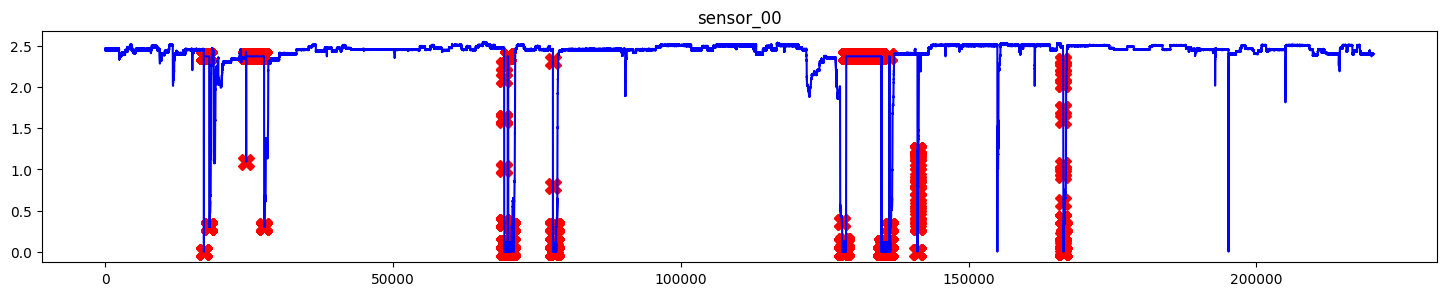

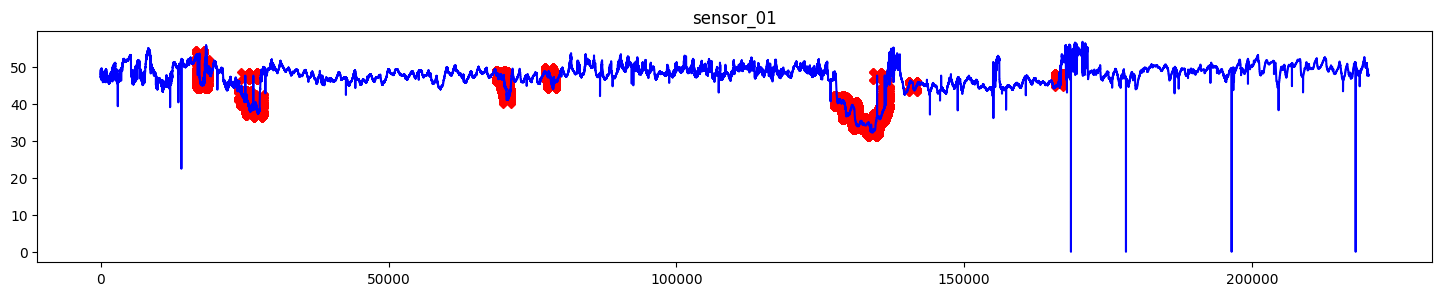

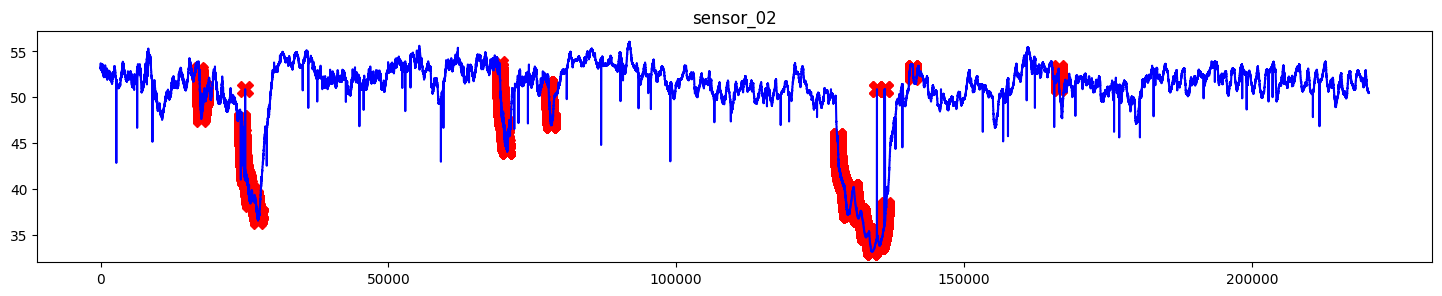

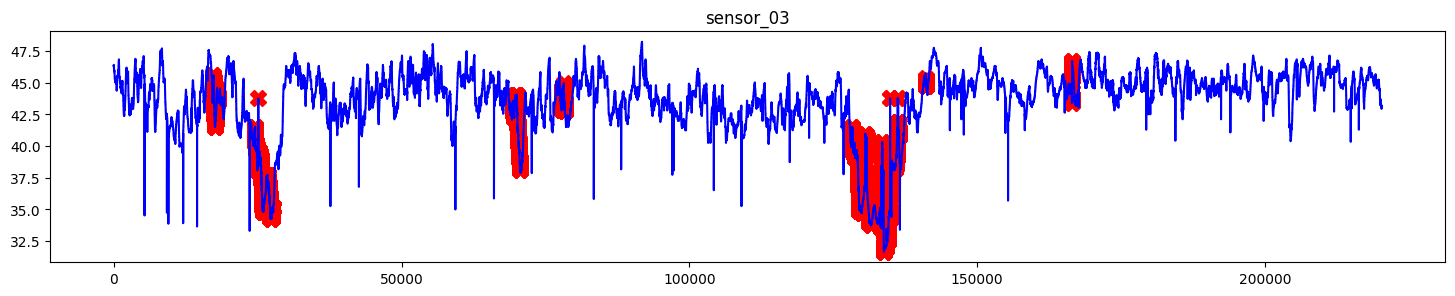

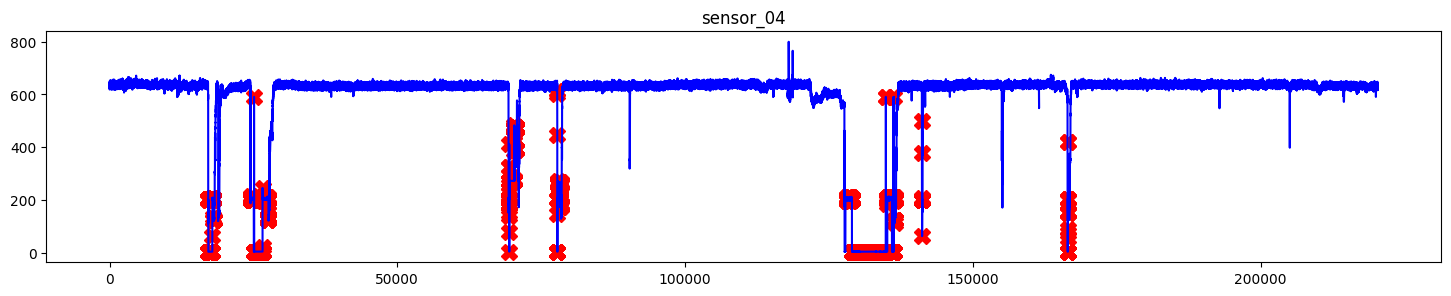

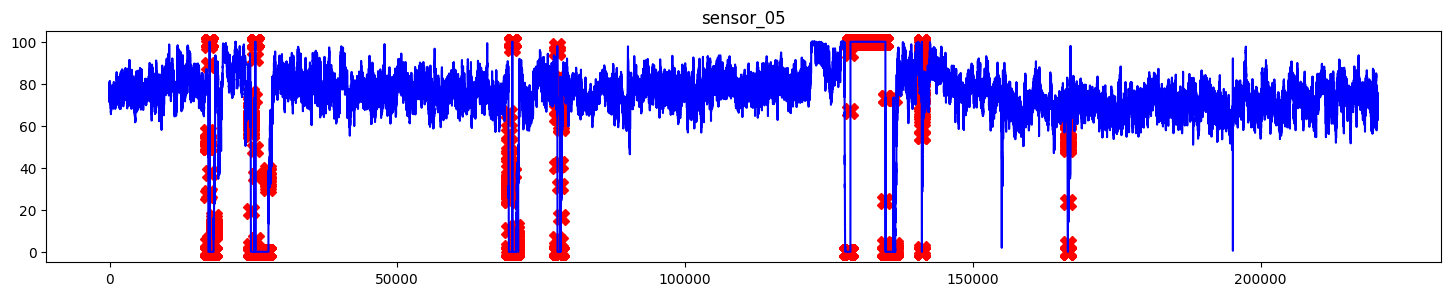

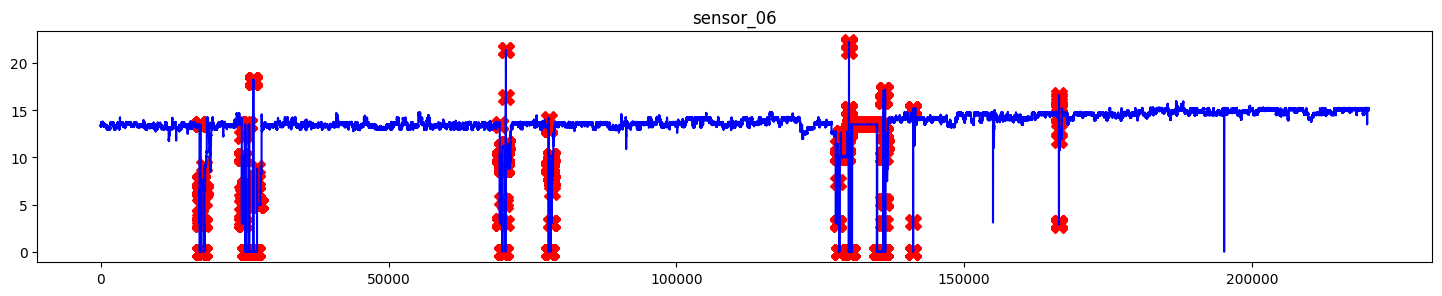

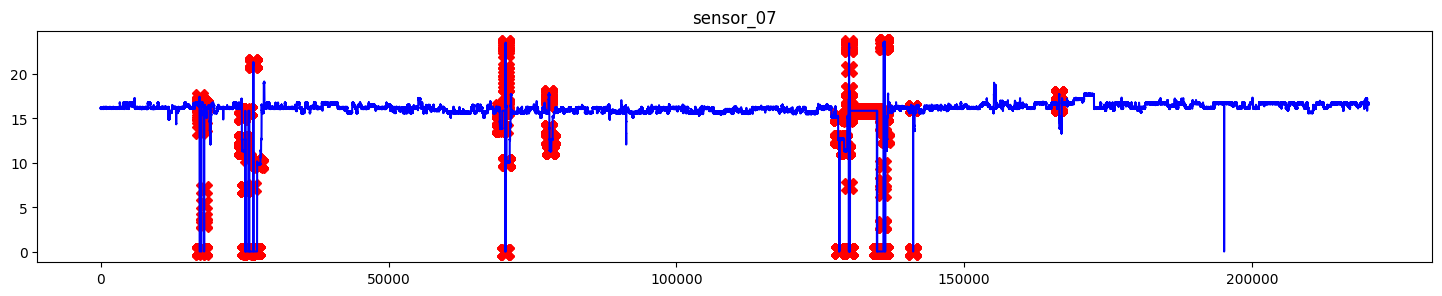

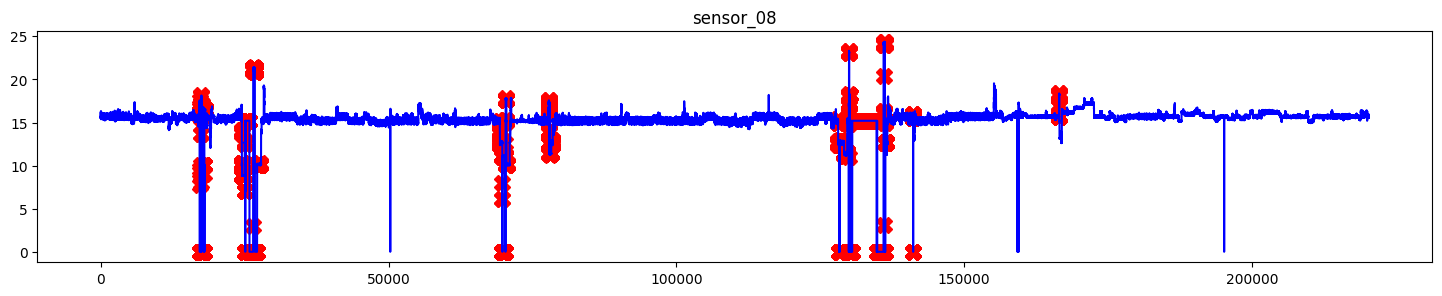

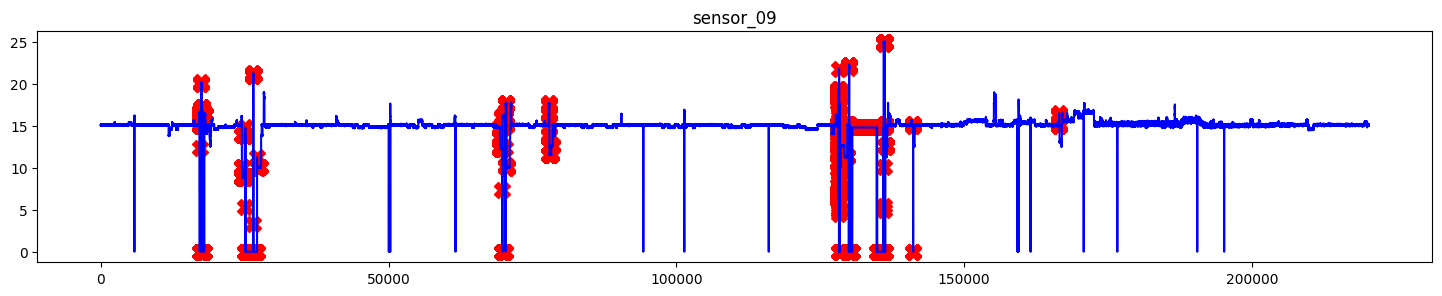

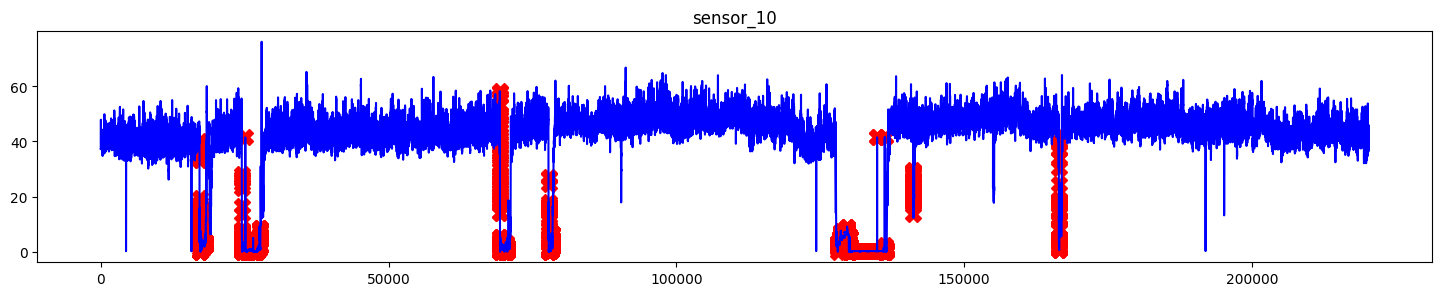

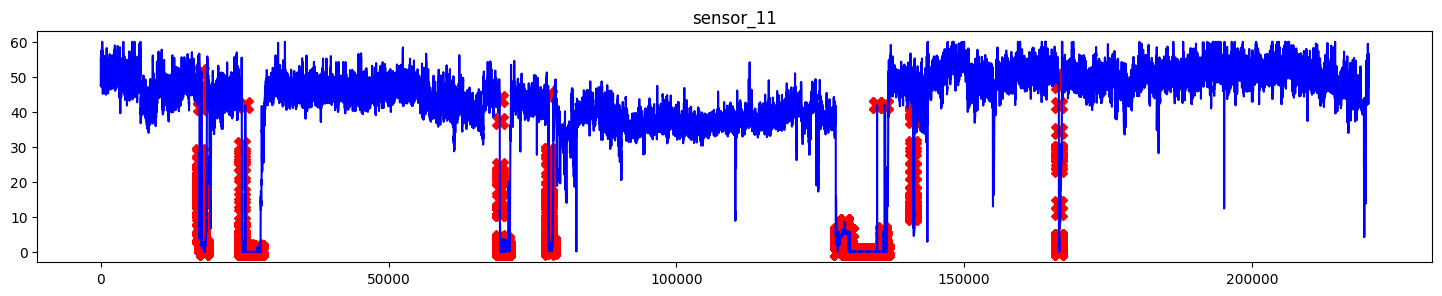

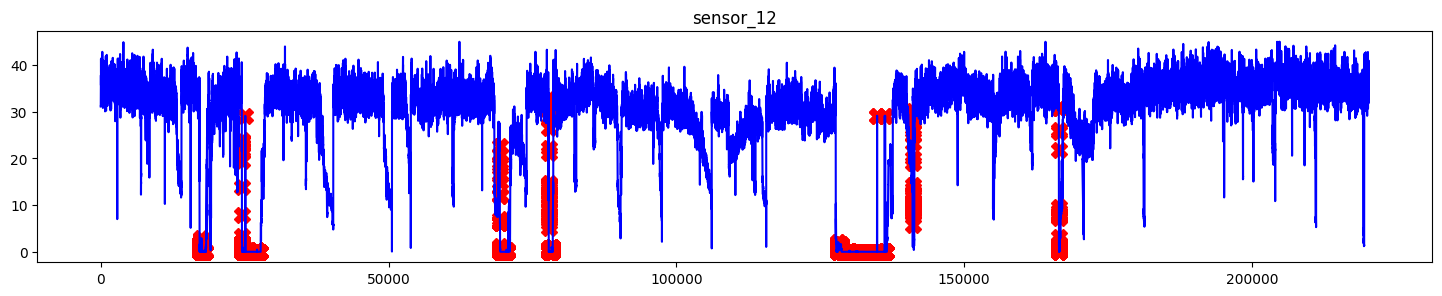

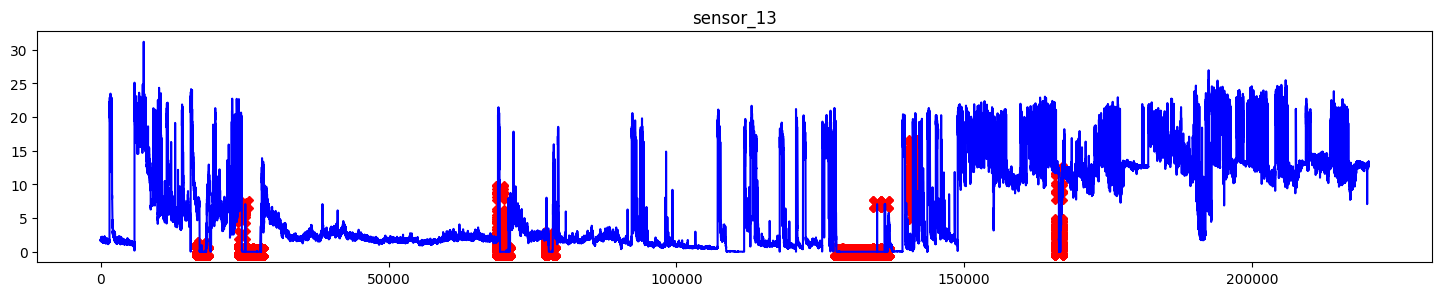

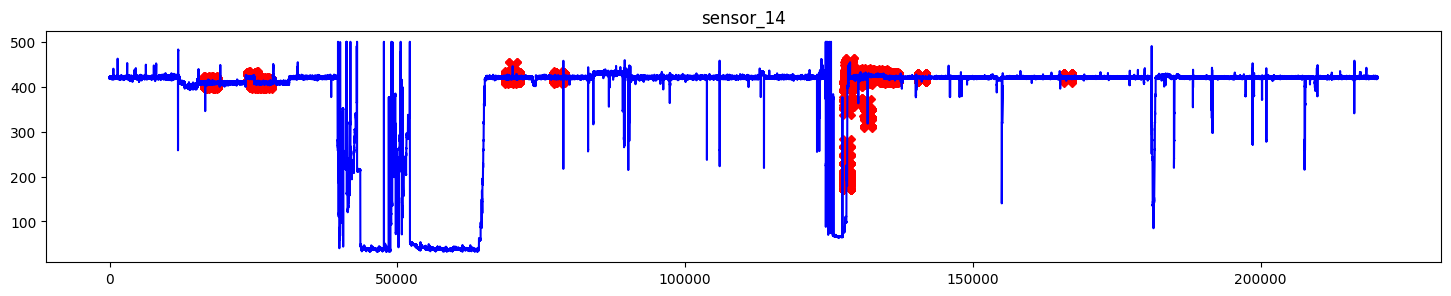

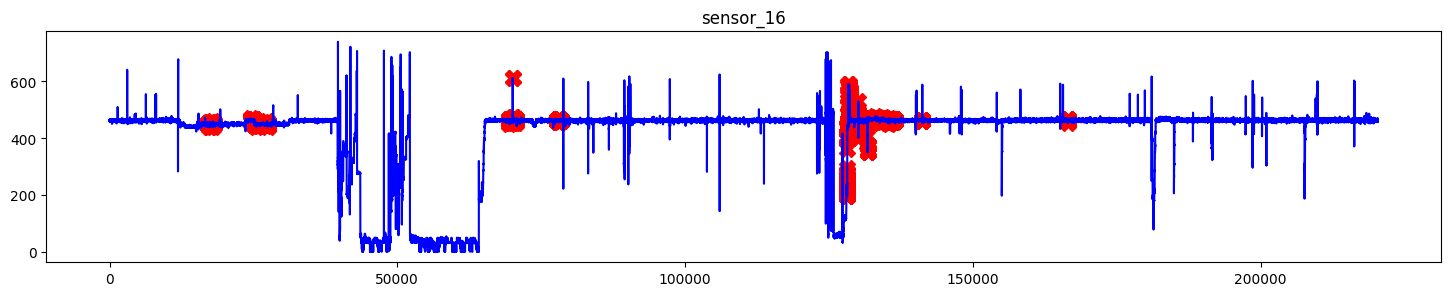

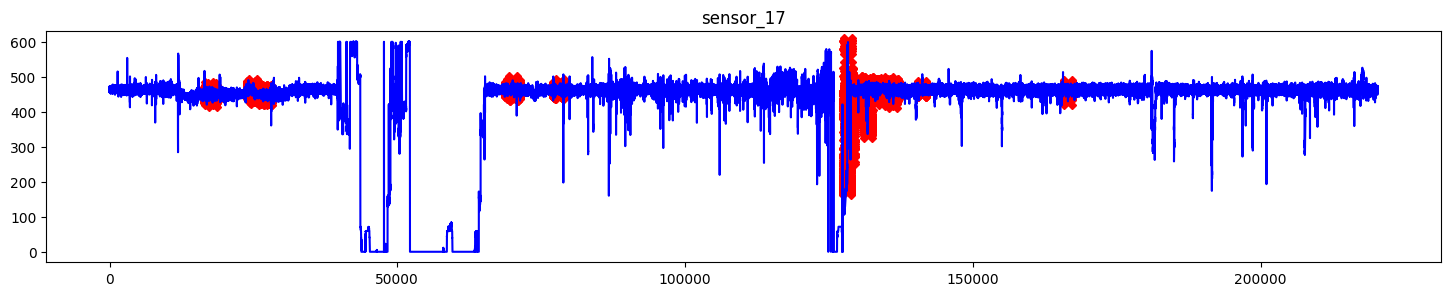

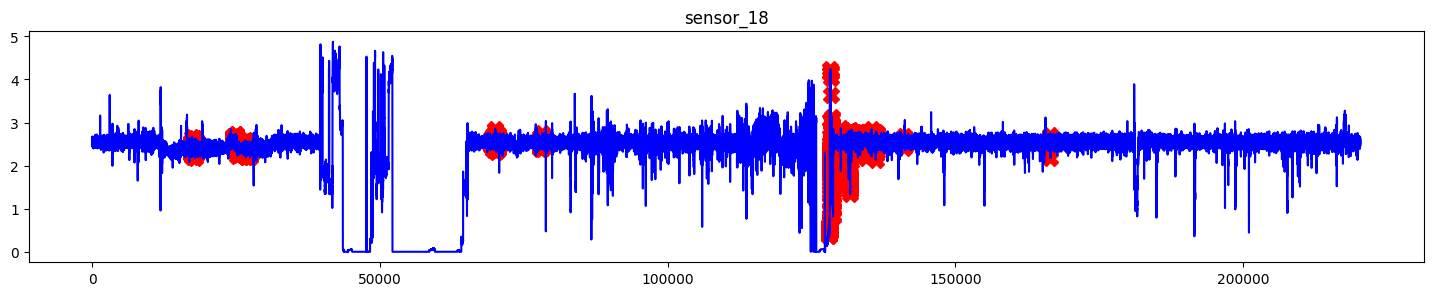

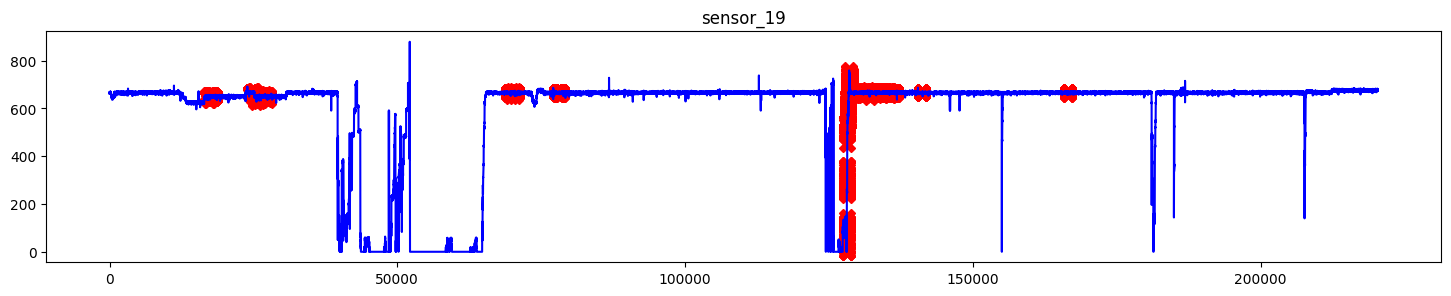

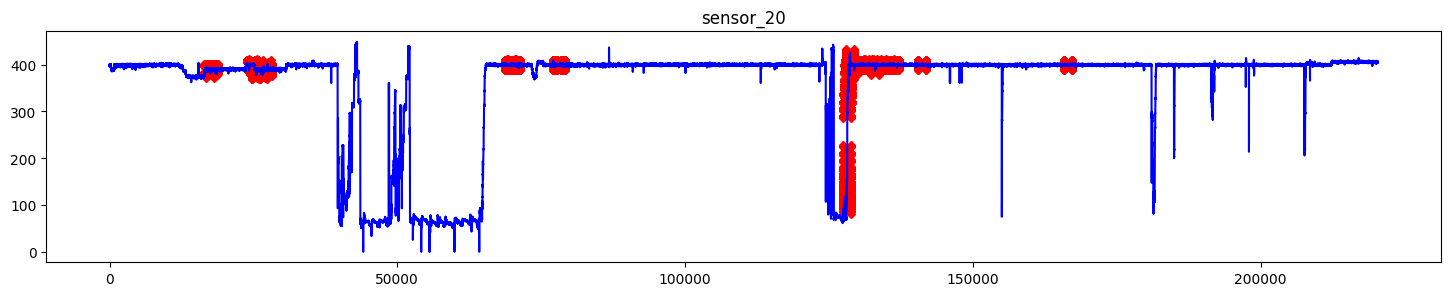

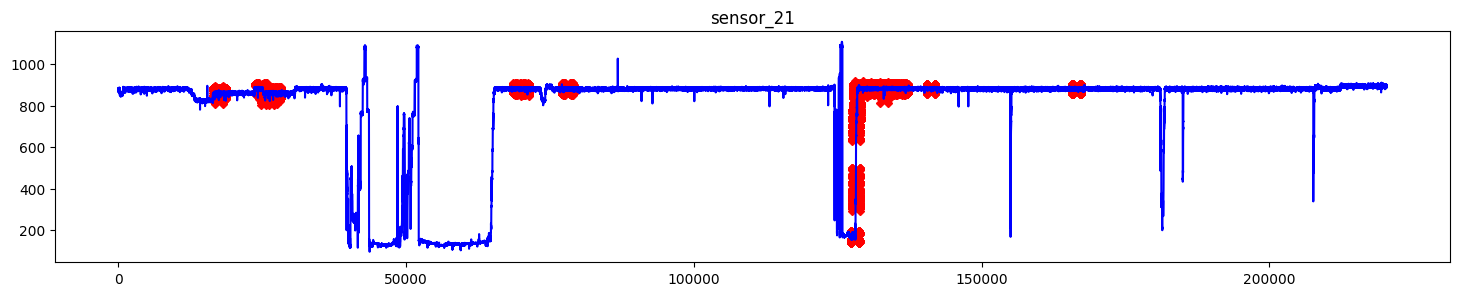

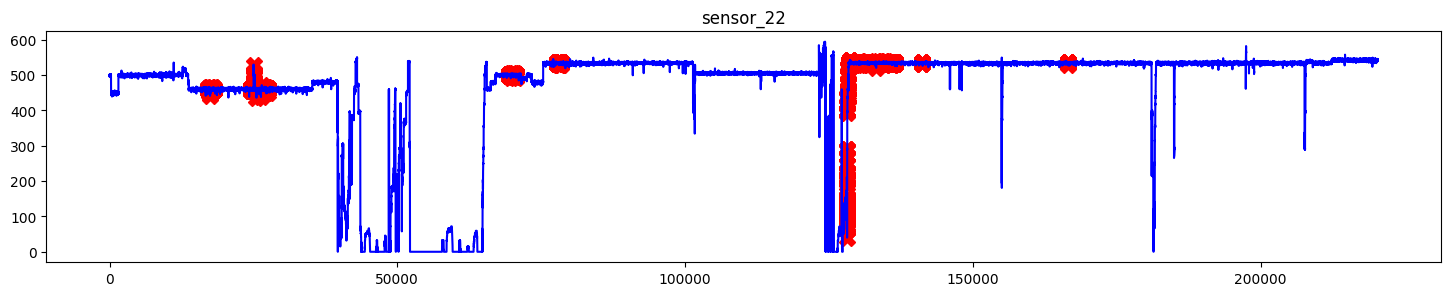

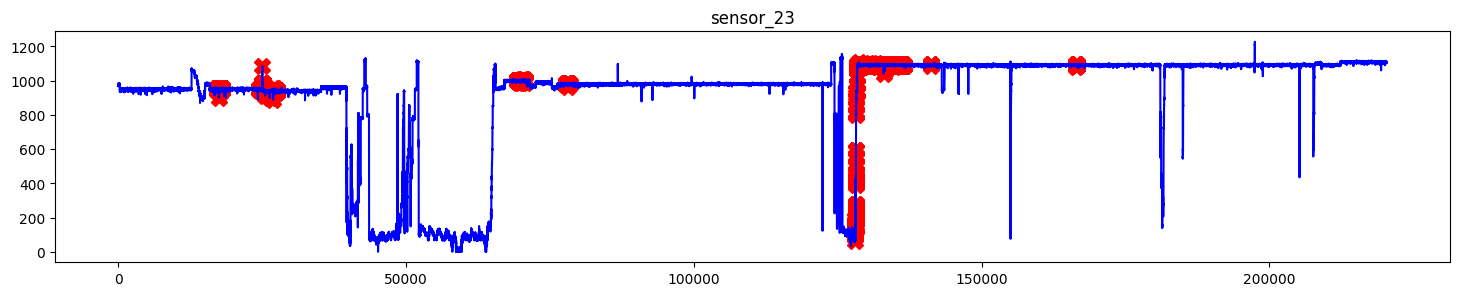

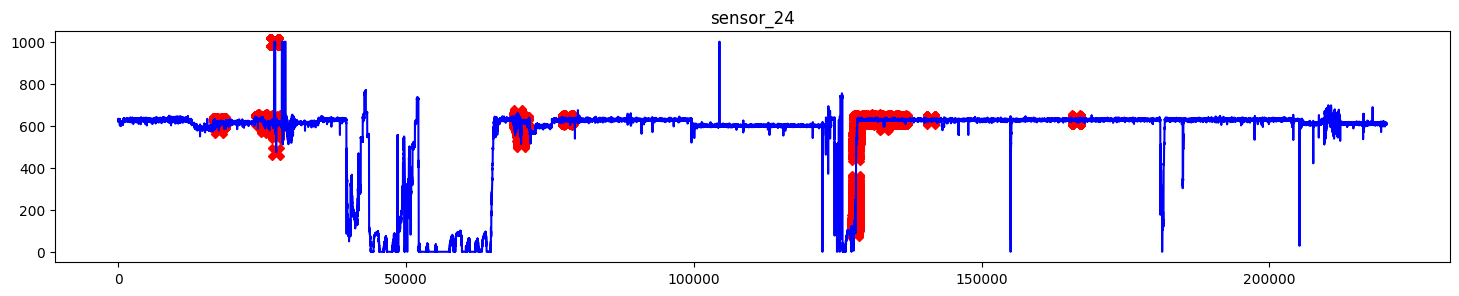

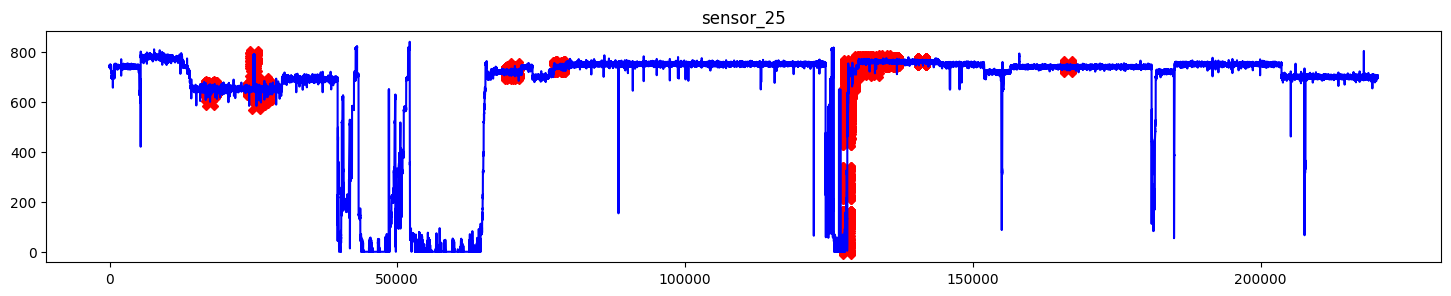

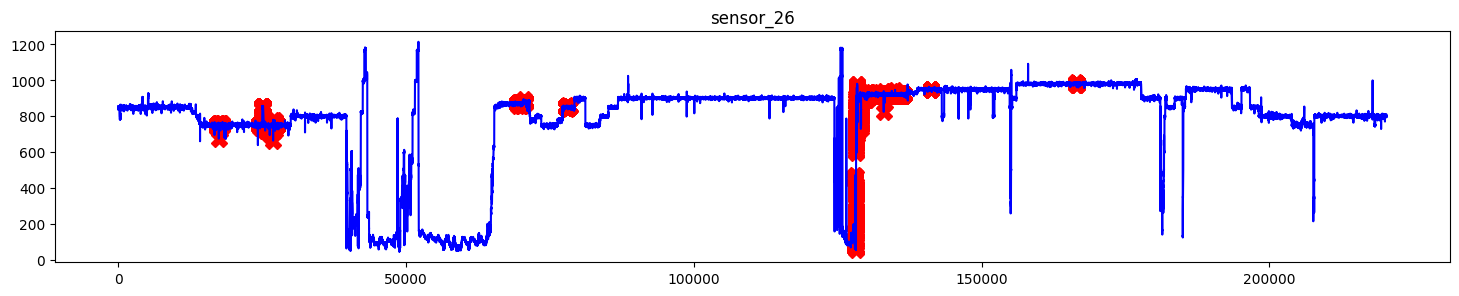

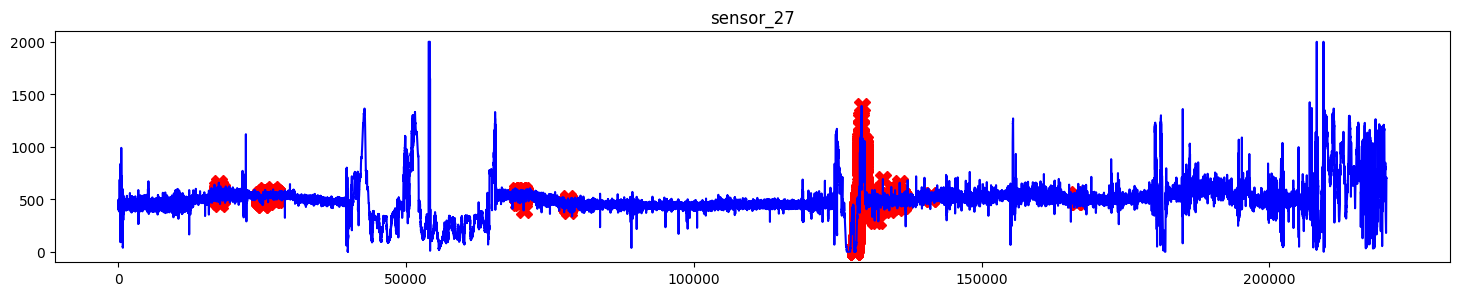

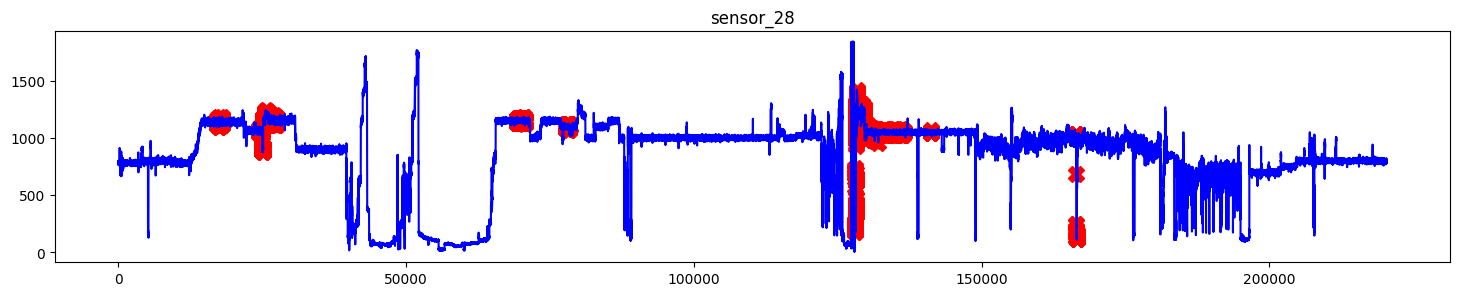

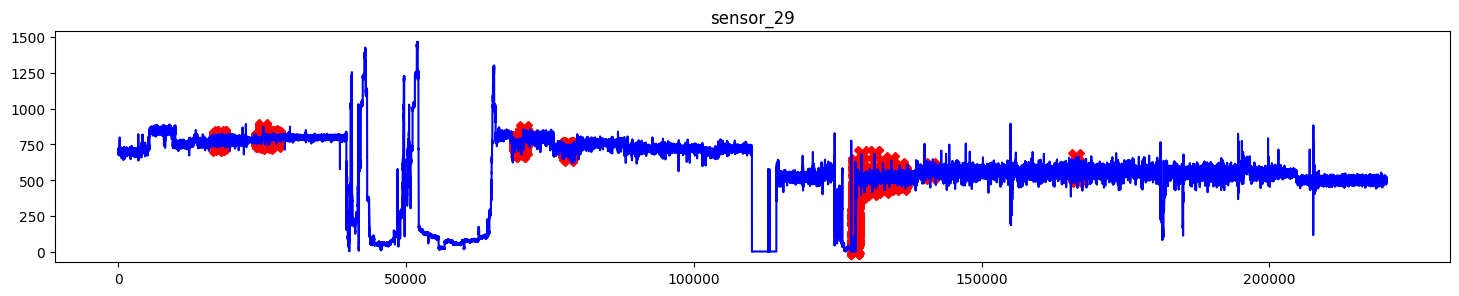

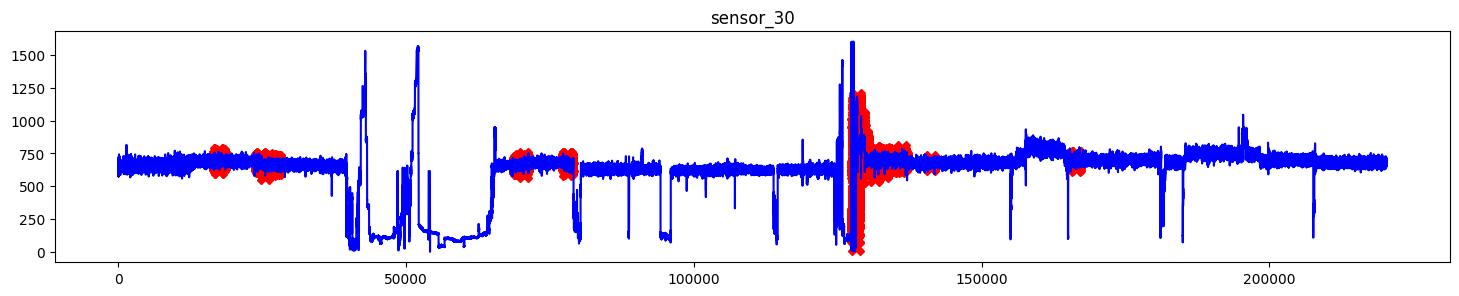

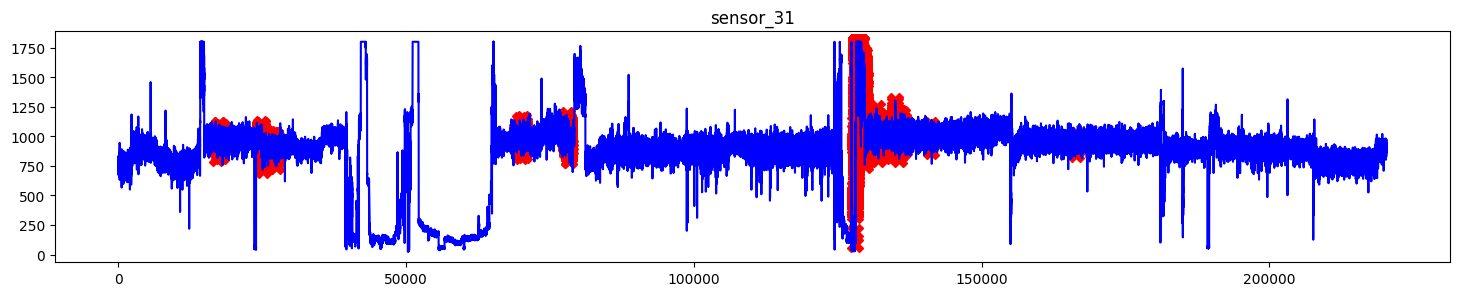

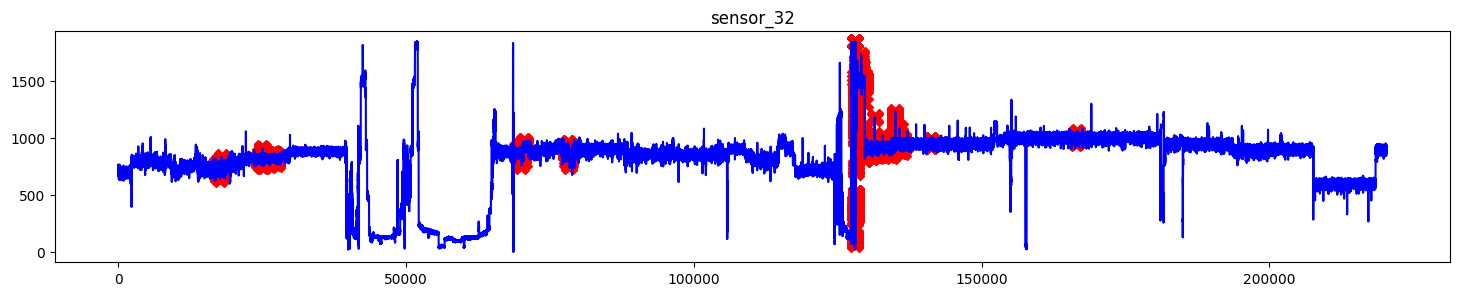

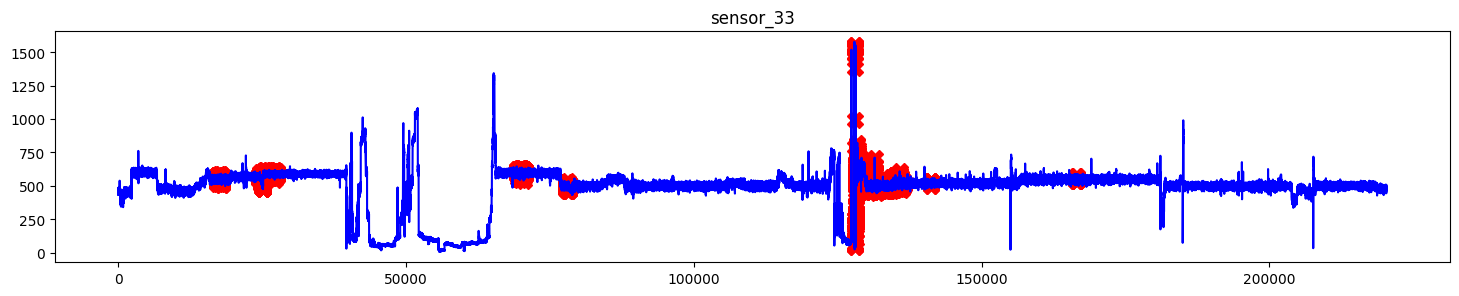

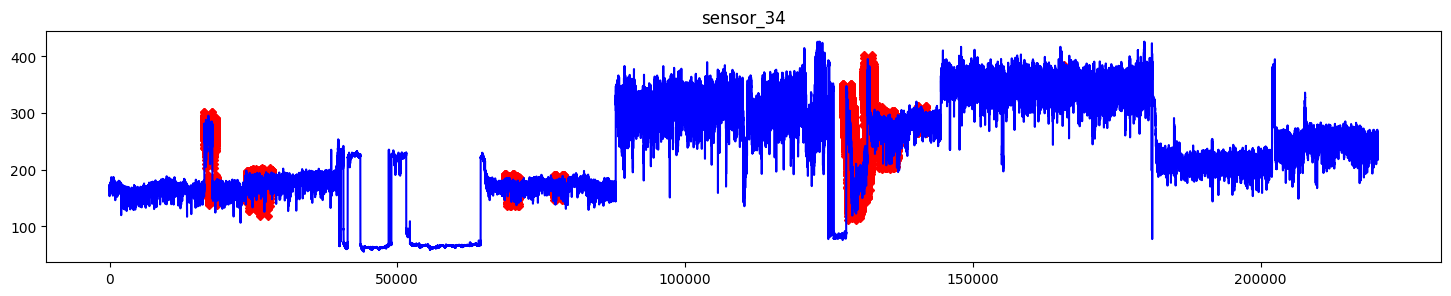

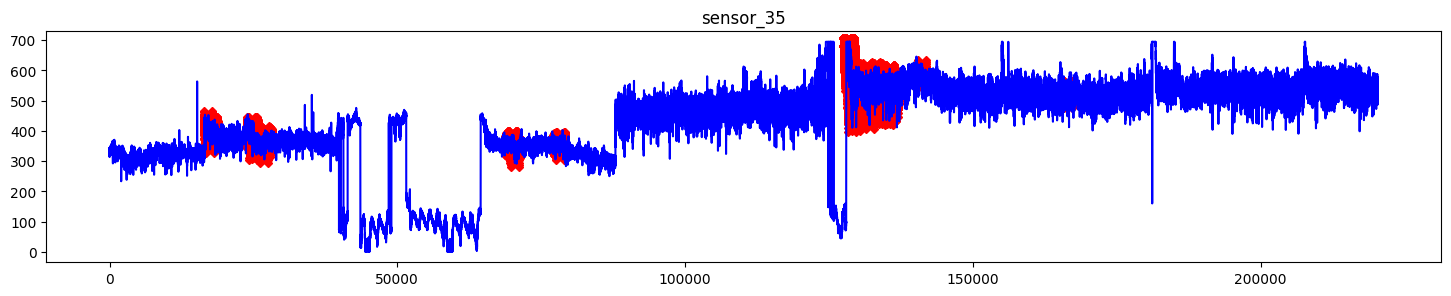

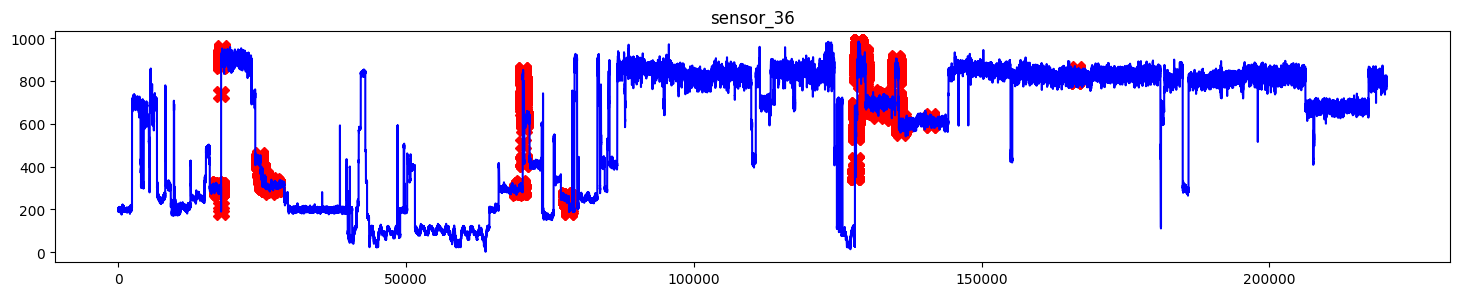

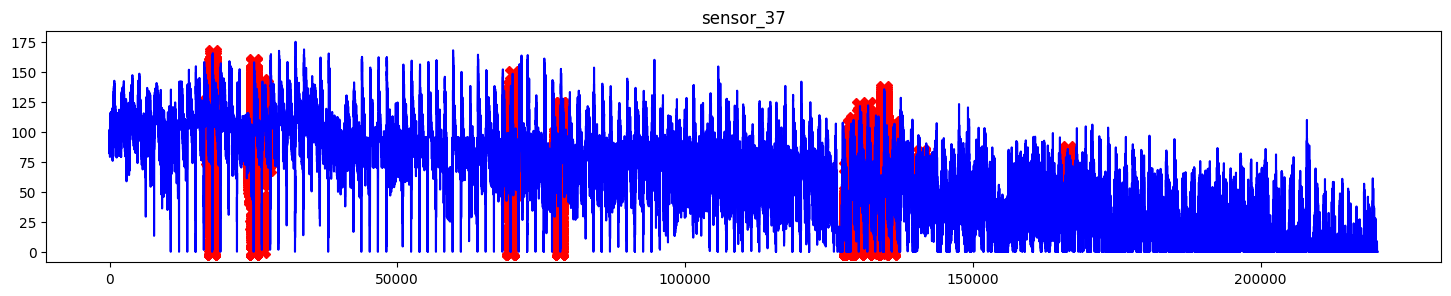

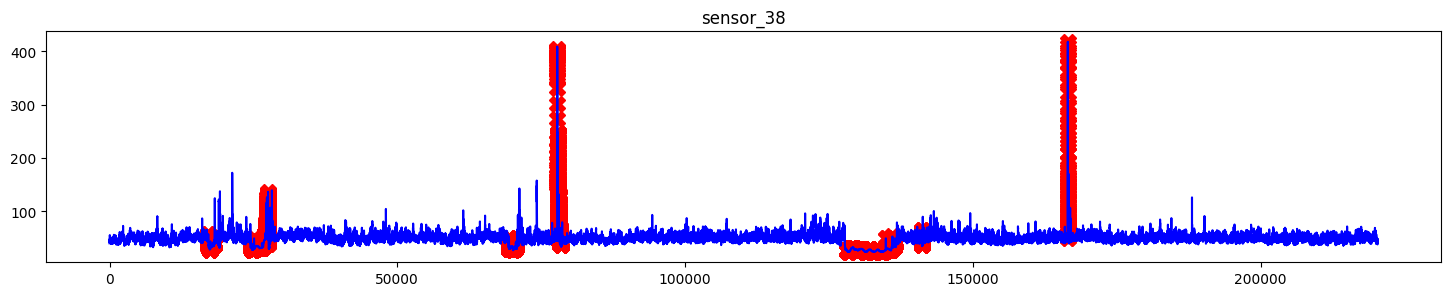

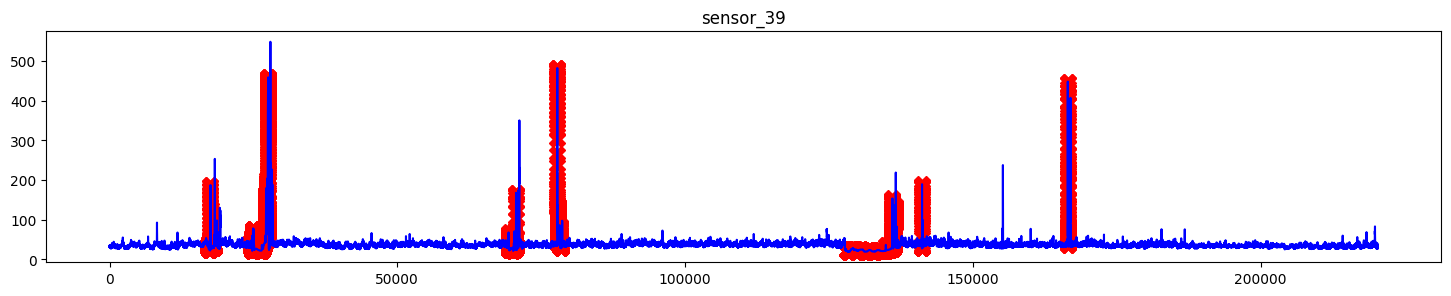

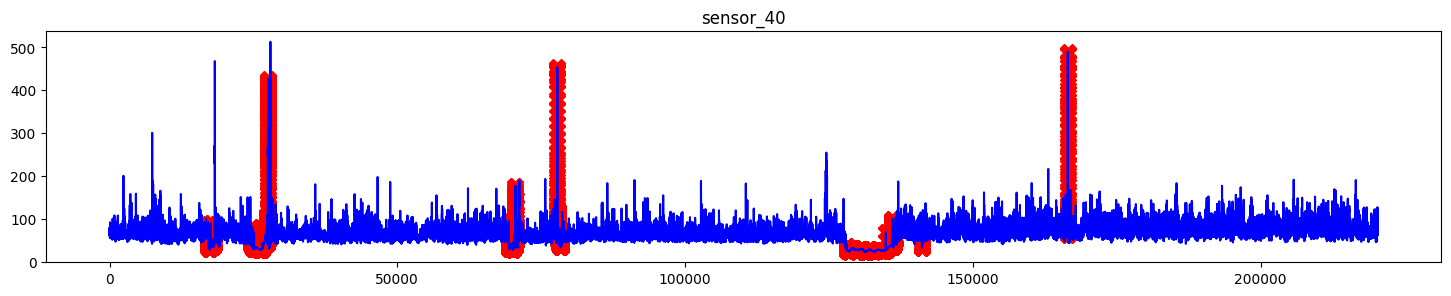

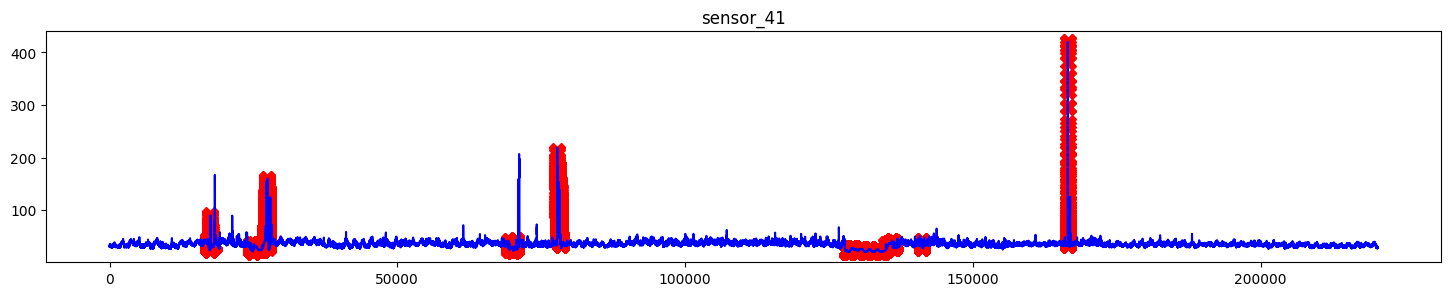

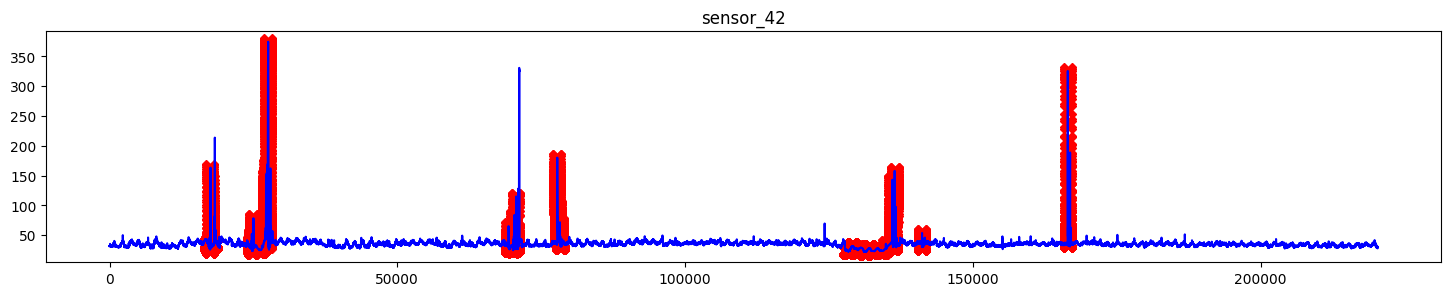

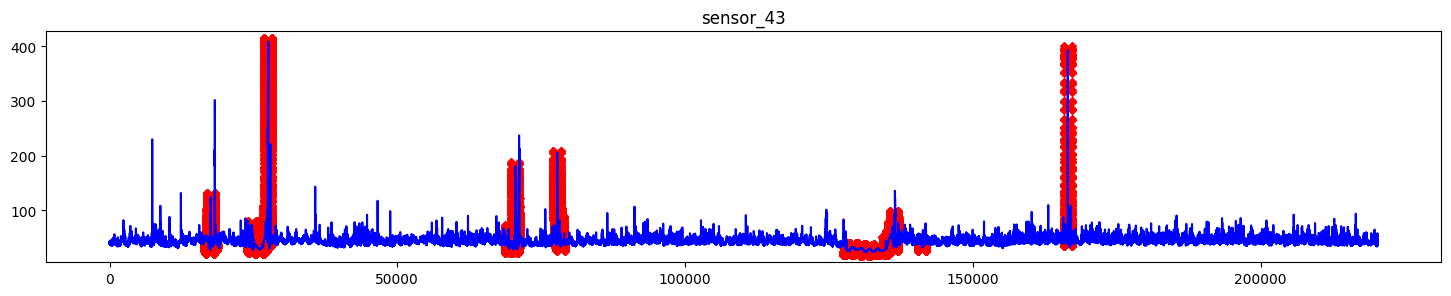

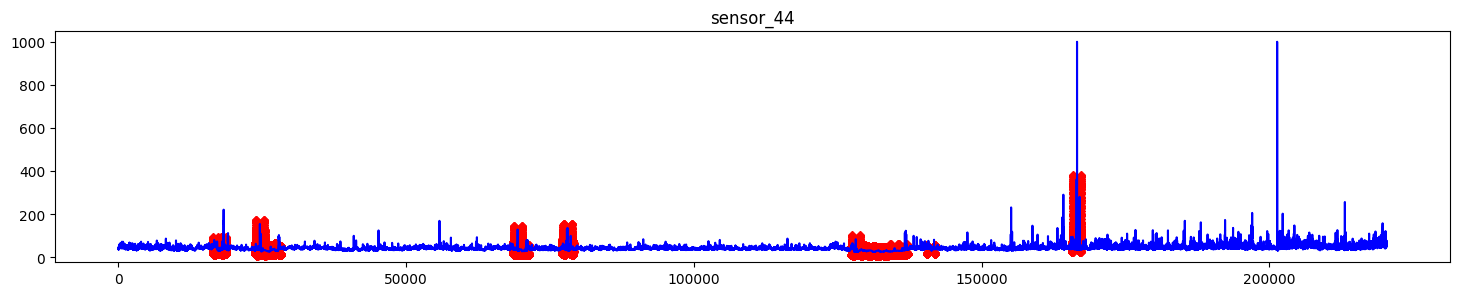

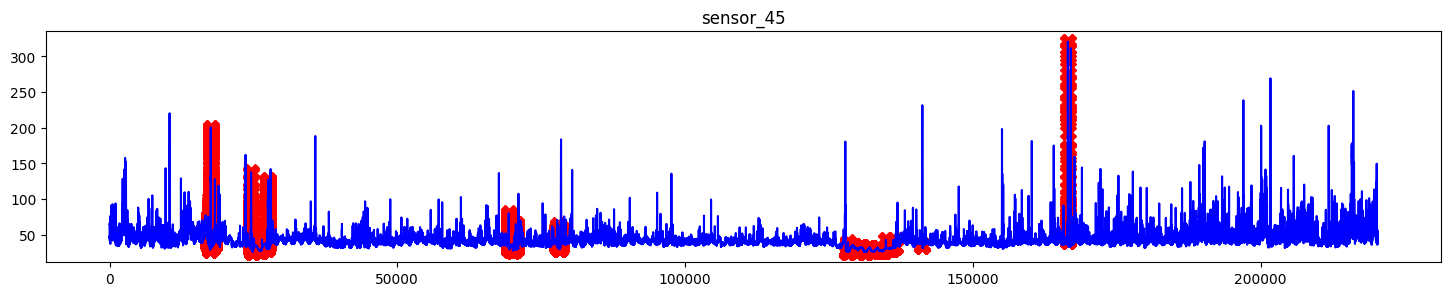

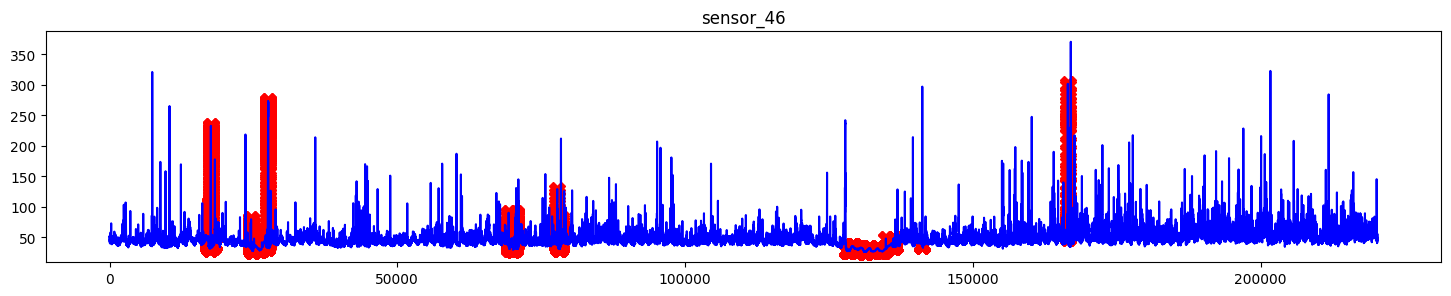

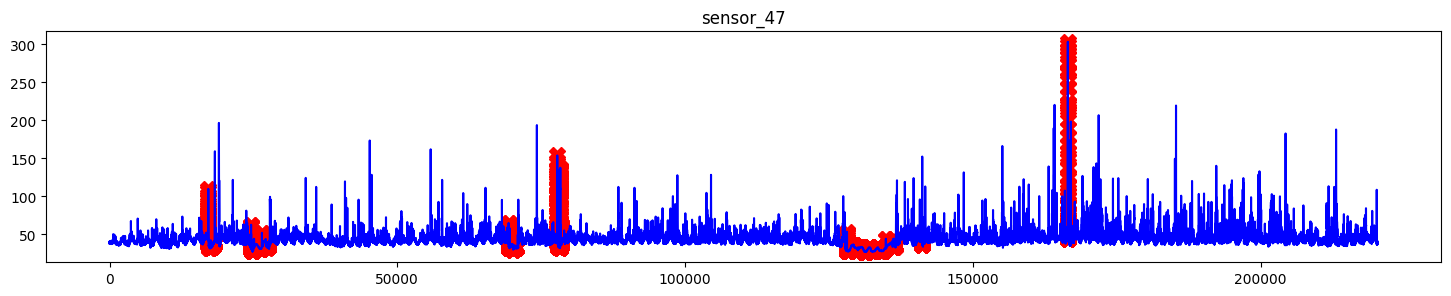

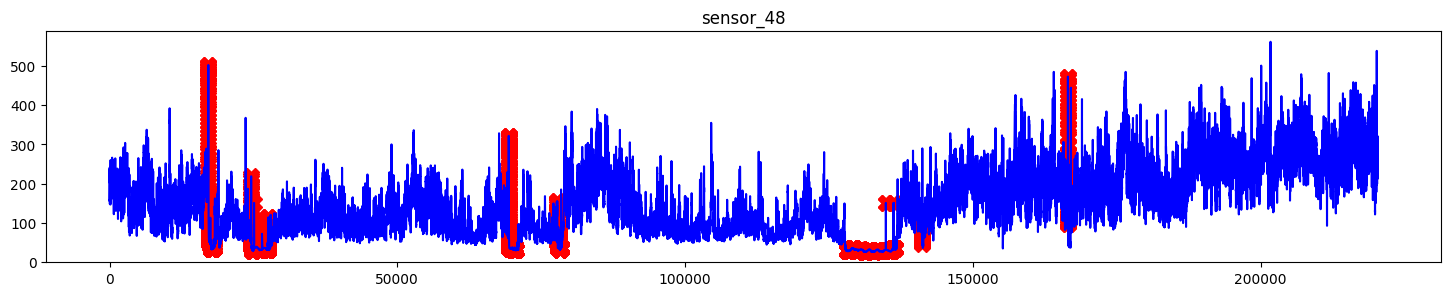

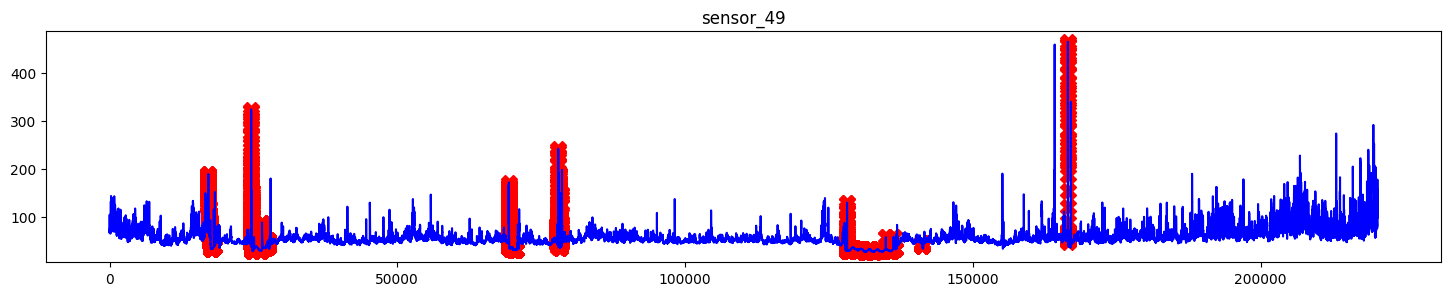

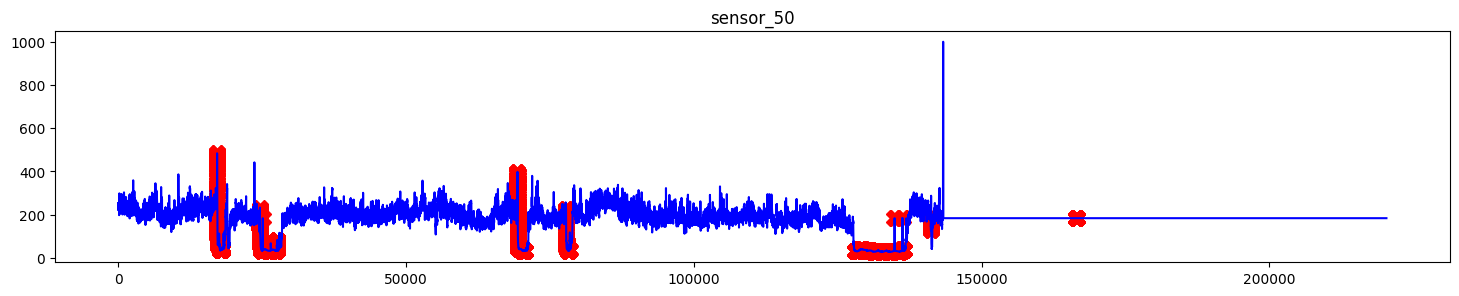

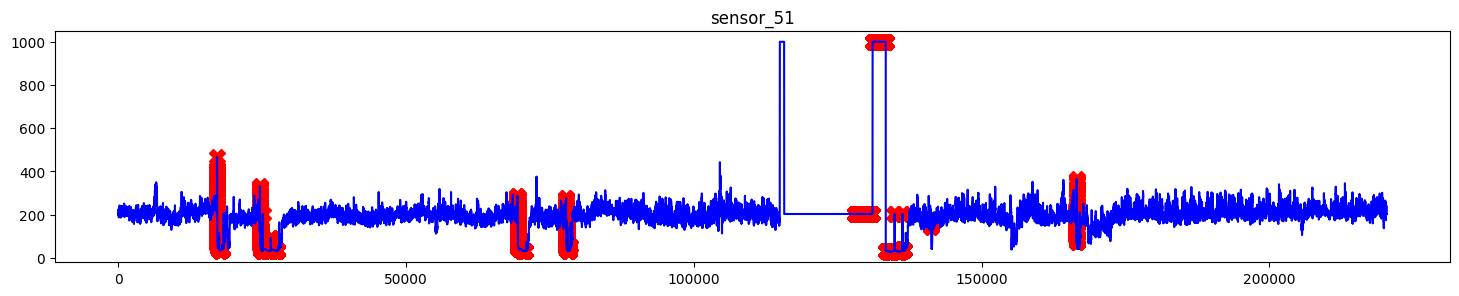

In [65]:

# Esta aproximación a la visualización sería con datos balanceados (o intento de)
broken_rec = df[df['machine_status'] !=  'NORMAL' ]

# Extraemos columnas numéricas solo, es decir quitamos machine_status y date
df2 = df.drop(['machine_status'], axis=1)
df2 = df2.drop(columns='date')
names=df2.columns

# Ploteamos series de tiempo para cada sensor con estado BROKEN o RECOVERING marcado con una X en rojo

for name in names:
    plt.figure(figsize=(18,3))
    plt.plot(broken_rec[name], linestyle='none', marker='X', color='red', markersize=12)
    plt.plot(df[name], color='blue')
    plt.title(name)
    plt.show()

In [54]:
def calculate_statistics(data):
    """ Calcula estadísticas de las lecturas de los sensores: media, desviación estándar, mediana y rango. """
    # Calcula media, desviación estándar y mediana
    means = data.mean(axis=0)
    std_devs = data.std(axis=0)
    medians = data.median(axis=0)
    
    # Calcula el rango (max - min)
    ranges = data.max(axis=0) - data.min(axis=0)
    
    return means, std_devs, medians, ranges

# 'numeric_normal', 'numeric_broken', 'numeric_recovering' son DataFrame pre-filtrados sin 'machine_status'
numeric_normal = normal.drop('machine_status', axis=1)
numeric_broken = broken.drop('machine_status', axis=1)
numeric_recovering = recovering.drop('machine_status', axis=1)

# Se calculan las estadísticas para cada estado operacional
stats_normal = calculate_statistics(numeric_normal)
stats_broken = calculate_statistics(numeric_broken)
stats_recovering = calculate_statistics(numeric_recovering)

# Se imprimen los resultados
states = ['NORMAL', 'ROTO', 'RECUPERÁNDOSE']
for i, stats in enumerate([stats_normal, stats_broken, stats_recovering]):
    print(f"Estado {states[i]}:")
    print("Media:\n", stats[0])
    print("Desviación Estándar:\n", stats[1])
    print("Mediana:\n", stats[2])
    print("Rango:\n", stats[3], "\n")

Estado NORMAL:
Media:
 sensor_00                         0.949571
sensor_01                          0.84931
sensor_02                         0.807807
sensor_03                         0.755519
sensor_04                         0.781324
sensor_05                         0.753897
sensor_06                         0.622871
sensor_07                         0.685095
sensor_08                         0.635245
sensor_09                         0.603466
sensor_10                         0.581665
sensor_11                         0.746162
sensor_12                         0.692716
sensor_13                         0.242812
sensor_14                         0.730762
sensor_16                         0.558968
sensor_17                         0.697618
sensor_18                         0.470002
sensor_19                         0.666922
sensor_20                         0.798496
sensor_21                         0.687374
sensor_22                         0.768503
sensor_23                      

TODO - Plotear medianas, los ranges tmb


Se intenta buscar la correlación de los datos (en este caso utilizando el dataset original)

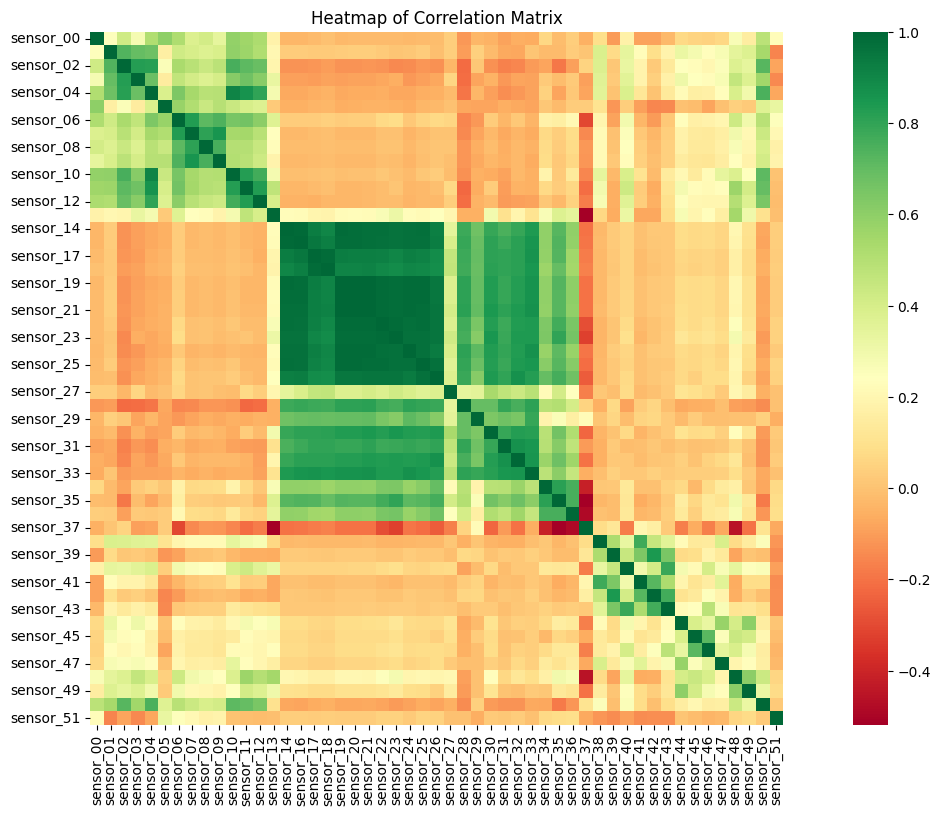

In [52]:
df_aux = df.select_dtypes(include=[np.number])
correlation_matrix = df_aux.corr()

# Let's see a heatmap for correlation
_ = plt.figure(figsize=(18,9))
sns.heatmap(correlation_matrix, square=True, cmap='RdYlGn')
plt.title('Heatmap of Correlation Matrix')
plt.show()

### Reduciendo dimensiones

In [74]:
from sklearn.decomposition import PCA
features=['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51']

# Estandarización de los datos antes de aplicar PCA
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Se aplica PCA reduciendo a dos componentes principales
pca = PCA(n_components=2)
x = df_scaled.loc[:, features].values
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
finalDf = pd.concat([principalDf, df_scaled[['machine_status']]], axis = 1)


finalDf.head()

,pc1,pc2,machine_status
0,-0.006837,-0.002113,NORMAL
1,-0.006837,-0.002113,NORMAL
2,-0.018820,-0.008814,NORMAL
3,-0.009916,-0.005489,NORMAL
4,-0.011873,-0.016353,NORMAL


In [75]:
finalDf.describe().T

,count,mean,std,min,25%,50%,75%,max
pc1,220320.0,-5.985690e-17,0.859420,-1.003946,-0.407218,-0.332005,-0.077947,2.652996
pc2,220320.0,1.155857e-16,0.471022,-0.667198,-0.292656,-0.063495,0.053741,2.071462


# Detección de anomalías

## Métodos no incrementales

### Rango Intercuartil

En esta práctica, se utiliza el IQR para detectar outliers o valores atípicos, esto se realiza calculando el IQR para los componentes principales obtenidos a través del PCA, combinaciones lineales de las variables originales y que representan nuevas dimensiones al capturar la mayor parte de la variabilidad de los datos.

Los límites para determinar los outliers se establecen a 1.5 veces el IQR por debajo del Q1 y por encima del Q3, cualquier punto de dato que caiga fuera es un outlier.

El uso del IQR es particularmente útil en este contexto porque es menos susceptible a los extremos que otras medidas, como la desviación estándar. Esto es crítico en la práctica porque en los datos industriales y científicos, los outliers pueden indicar errores de medición, defectos en el equipo, o condiciones operativas anormales que son vitales para la toma de decisiones correctivas. 

Identificar correctamente estos outliers puede ayudar a prevenir fallas, optimizar operaciones y garantizar la calidad y seguridad en los distintos procesos.

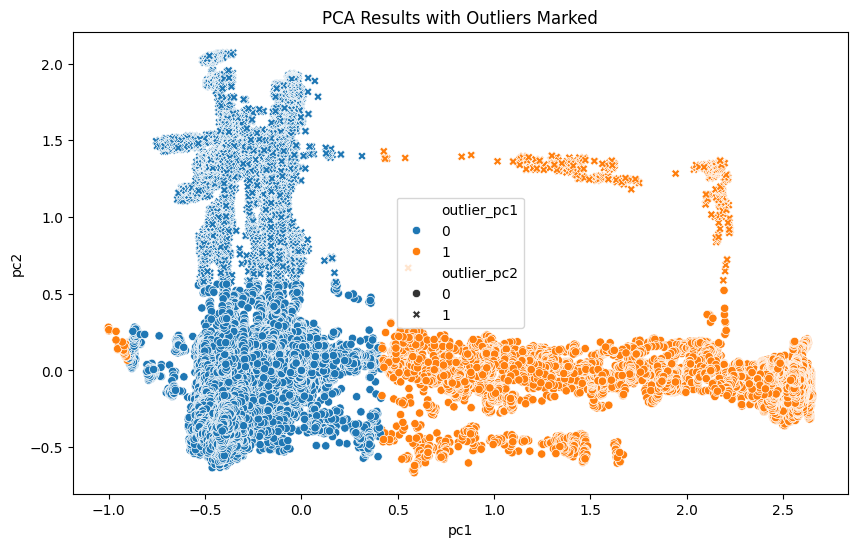

In [76]:
def calculate_iqr(data, column_name):
    '''
        Cálculo del IQR para cada componente principal
    '''
    q1 = data[column_name].quantile(0.25)
    q3 = data[column_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

lower_pc1, upper_pc1 = calculate_iqr(finalDf, 'pc1')
lower_pc2, upper_pc2 = calculate_iqr(finalDf, 'pc2')

# Identificación de outliers basados en IQR
finalDf['outlier_pc1'] = ((finalDf['pc1'] < lower_pc1) | (finalDf['pc1'] > upper_pc1)).astype(int)
finalDf['outlier_pc2'] = ((finalDf['pc2'] < lower_pc2) | (finalDf['pc2'] > upper_pc2)).astype(int)

# Visualización de resultados
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pc1', y='pc2', hue='outlier_pc1', style=finalDf['outlier_pc2'], data=finalDf)
plt.title('PCA Results with Outliers Marked')
plt.show()

Esto es otra manera de hacerlo, en esta sección se haría el cálculo del IQR y la determinación de los valores atípicos

In [79]:
# Calcular IQR para el primer componente principal (pc1)
q1_pc1, q3_pc1 = finalDf['pc1'].quantile([0.25, 0.75])
iqr_pc1 = q3_pc1 - q1_pc1

# Calcular límites superior e inferior para valores atípicos en pc1
lower_pc1 = q1_pc1 - (1.5 * iqr_pc1)
upper_pc1 = q3_pc1 + (1.5 * iqr_pc1)

# Filtrar los valores atípicos de pc1
finalDf['anomaly_pc1'] = ((finalDf['pc1'] > upper_pc1) | (finalDf['pc1'] < lower_pc1)).astype(int)

# Calcular IQR para el segundo componente principal (pc2)
q1_pc2, q3_pc2 = finalDf['pc2'].quantile([0.25, 0.75])
iqr_pc2 = q3_pc2 - q1_pc2
lower_pc2 = q1_pc2 - (1.5 * iqr_pc2)
upper_pc2 = q3_pc2 + (1.5 * iqr_pc2)

# Filtrar los valores atípicos de pc2
finalDf['anomaly_pc2'] = ((finalDf['pc2'] > upper_pc2) | (finalDf['pc2'] < lower_pc2)).astype(int)

In [81]:
print(df.columns)  # Verificar columnas en el DataFrame original
print(finalDf.columns)  # Verificar columnas en el DataFrame final después de PCA y otras transformaciones

Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51', 'machine_status', 'date'],
      dtype='object')
Index(['pc1', 'pc2', 'machine_status', 'outlier_pc1', 'outlier_pc2',
       'anomaly_pc1', 'anomaly_pc2'],
      dtype='object')


Detectando anomalías en el sensor 11

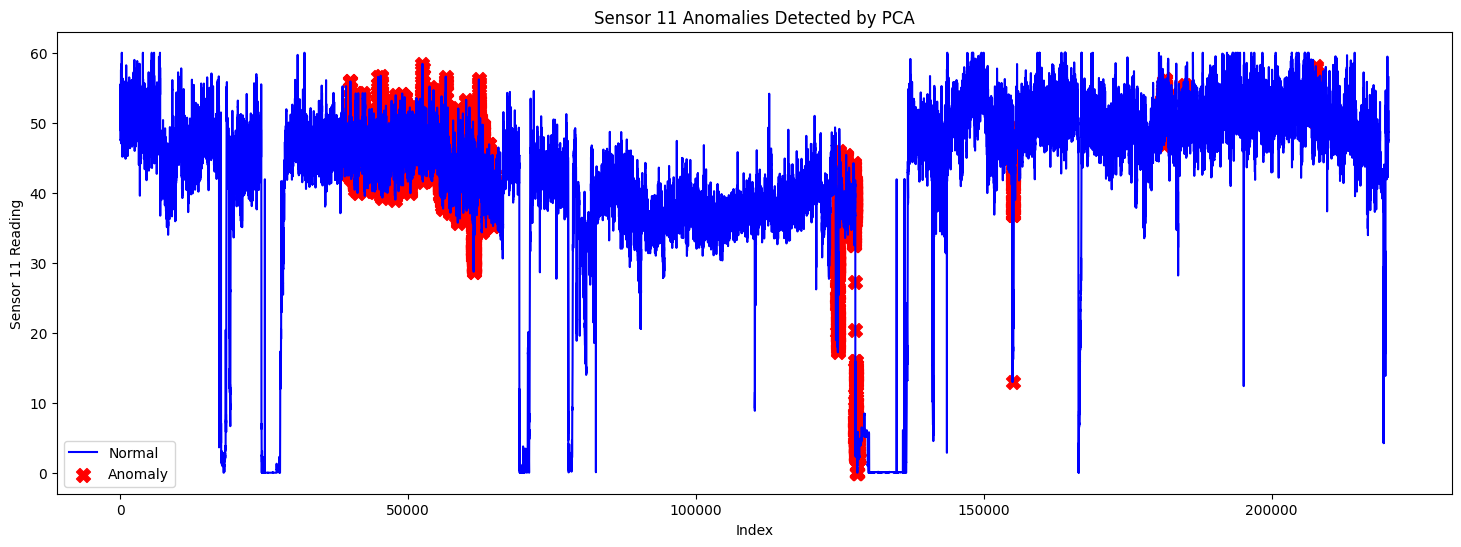

In [82]:
import matplotlib.pyplot as plt

# Se filtran las anomalías en pc1 utilizando finalDf
anomalias = finalDf[finalDf['anomaly_pc1'] == 1]

# ploteamos valores de sensor_11 del DataFrame df
plt.figure(figsize=(18, 6))
plt.plot(df['sensor_11'], color='blue', label='Normal')

# Las anomalías quedan marcadas en rojo
plt.scatter(anomalias.index, df.loc[anomalias.index, 'sensor_11'], color='red', marker='X', s=100, label='Anomaly')

plt.xlabel('Index')
plt.ylabel('Sensor 11 Reading')
plt.title('Sensor 11 Anomalies Detected by PCA')
plt.legend()
plt.show()

In [ ]:
def outlier_treatment(datacolumn):
    sorted_data = np.sort(datacolumn)
    Q1, Q3 = np.percentile(sorted_data, [25, 75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range, upper_range

# Ejemplo de uso para pc1
lowerbound, upperbound = outlier_treatment(finalDf['pc1'])

### K-Means Clustering

El uso del algoritmo K-Means Clustering en esta práctica tiene como objetivo segmentar las lecturas de los sensores en grupos o clústeres basados en similitudes en sus características. 

Esta técnica de aprendizaje no supervisado agrupa los datos en un número predefinido de clústeres, en este caso basado en las principales componentes analizadas del conjunto de datos, reduciendo la complejidad y resaltando patrones subyacentes en el comportamiento de los sensores. 

Al asignar cada lectura de sensor a un clúster, podemos identificar qué conjunto de datos comparte características comunes y cómo se diferencian de otros grupos. 

Esto es especialmente útil para detectar condiciones operativas inusuales o para segmentar las condiciones de funcionamiento de la maquinaria, permitiendo así intervenciones más dirigidas y optimización en el mantenimiento y la operación de los equipos. 

K-Means proporciona una forma clara y visual de comprender la agrupación de los datos y es útil para la toma de decisiones en entornos industriales donde se manejan grandes volúmenes de datos de sensores.

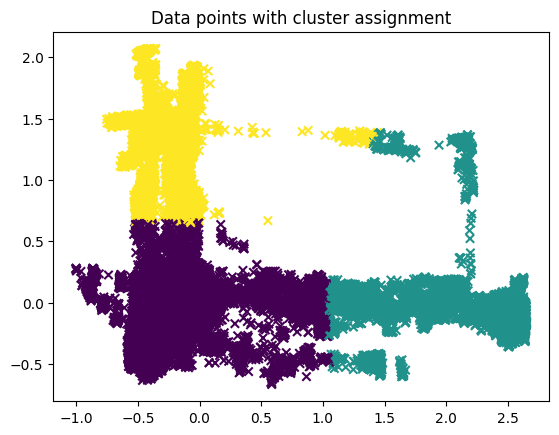

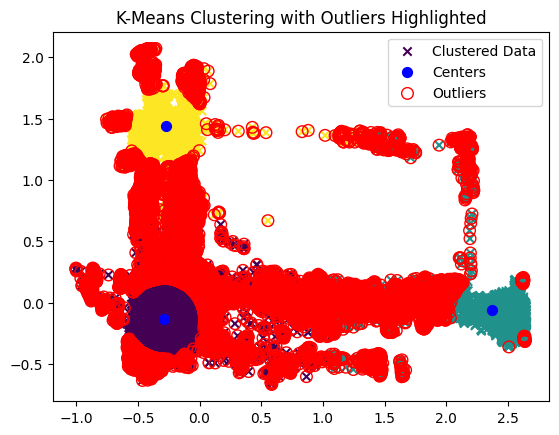

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Utilizando 'pc1' y 'pc2' de finalDf para el clustering
data = finalDf[['pc1', 'pc2']].values  # Asegúrate de que finalDf tiene las columnas 'pc1' y 'pc2'

# KMeans model, setting k = 3
km = KMeans(n_clusters=3)
clusters = km.fit_predict(data)

# Plotting dataset
plt.scatter(data[:, 0], data[:, 1], c=clusters, marker='x')
plt.title("Data points with cluster assignment")

# Obtaining the centers of the clusters
centroids = km.cluster_centers_

# Calculating distances from each point to its cluster center
distances = []
points = []

for i, center_elem in enumerate(centroids):
    # cdist is used to calculate the distance between center and other points
    cluster_points = data[clusters == i]
    cluster_distances = cdist([center_elem], cluster_points, 'euclidean')[0]
    distances.extend(cluster_distances)
    points.extend(cluster_points)

# Converting lists to numpy arrays for indexing
points = np.array(points)
distances = np.array(distances)

# Identifying outliers as those beyond the 80th percentile of distances
percentile = 80
threshold = np.percentile(distances, percentile)
outliers = points[distances > threshold]

# Plotting
fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], c=clusters, marker='x', label='Clustered Data')
ax.scatter(*zip(*centroids), marker='o', facecolor='b', edgecolor='b', s=50, label='Centers')
ax.scatter(*zip(*outliers), marker='o', facecolor='None', edgecolor='r', s=70, label='Outliers')
plt.title("K-Means Clustering with Outliers Highlighted")
plt.legend()
plt.show()


Asignación de Clústeres a los Datos:

En la primera gráfica:

Se muestra la distribución de los datos en el espacio de características (en este caso, dos dimensiones). 
Cada punto es una observación (o un registro) de los datos.
Los puntos están coloreados según el clúster al que han sido asignados por el algoritmo de K-Means. Esto se hace usando un modelo que divide el conjunto de datos en k grupos (donde k es el número de clústeres que se definió, en este caso 3) minimizando la varianza dentro de cada grupo.
Las marcas en forma de 'x' representan los puntos de datos y su color indica a qué clúster pertenecen según el algoritmo.

Visualización de Centros y Detección de Anomalías:

En la segunda gráfica:
Además de mostrar los puntos de datos con sus respectivos clústeres, se resaltan los centros de cada clúster con un marcador en forma de círculo ('o') lleno de color azul. Estos centros son los puntos promedio de cada clúster y representan el "centroide", es decir, el corazón de cada grupo.

Además, se identifican los outliers o anomalías en la gráfica. Estos se muestran con círculos vacíos de borde rojo y son más grandes que los puntos de datos normales. Estos outliers son puntos de datos que están a una distancia considerable de sus centros de clúster respectivos. Para identificarlos, se utiliza un cálculo de distancias desde cada punto hasta su centroide y se consideran como outliers aquellos que están más allá del percentil 80 de estas distancias.
Estos outliers pueden ser de especial interés ya que podrían indicar errores de medición, eventos raros o condiciones anormales que podrían requerir una investigación adicional.

### Isolation Forest

Se está utilizando el método Isolation Forest para identificar anomalías o comportamientos atípicos en los datos recopilados de sensores en una máquina. 

Es un modelo particularmente efectivo para detectar outliers porque funciona bajo el principio de que las anomalías son pocas y diferentes en sus características en comparación con los valores normales. 

Al establecer un 13% de contaminación, asumimos que aproximadamente el 13% de los datos son anómalos. Esta técnica es útil en escenarios industriales para prevenir fallos, optimizar operaciones y garantizar la seguridad al alertar sobre lecturas inusuales que podrían indicar un problema potencial. 

Al aplicar Isolation Forest a las componentes principales obtenidas del análisis PCA, buscamos simplificar la dimensionalidad de los datos conservando solo las características más significativas, facilitando así una detección de anomalías más efectiva y eficiente

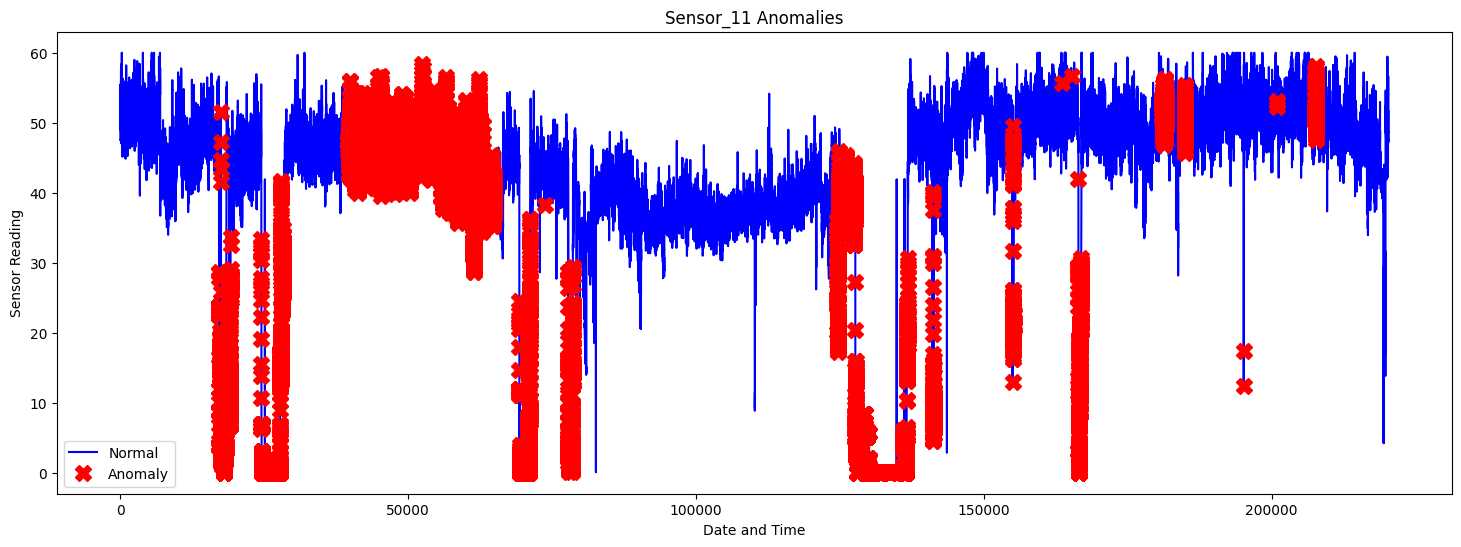

In [85]:
from sklearn.ensemble import IsolationForest
import pandas as pd
import matplotlib.pyplot as plt

data = finalDf[['pc1', 'pc2']].values

# Se configura un factor de contaminación del 13%.

outliers_fraction = 0.13
model = IsolationForest(contamination=outliers_fraction)
model.fit(data)

# Los resultados del modelo se integran en finalDf y luego se transfieren a df para la visualización
finalDf['anomaly2'] = pd.Series(model.predict(data), index=finalDf.index)

# Se añaden las anomalías 
df['anomaly2'] = finalDf['anomaly2']

# Filtrado de anomalías
anomalies = df[df['anomaly2'] == -1]  # anomaly

# Visualización
plt.figure(figsize=(18,6))
plt.plot(df['sensor_11'], color='blue', label='Normal')
plt.plot(anomalies['sensor_11'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
plt.xlabel('Date and Time')
plt.ylabel('Sensor Reading')
plt.title('Sensor_11 Anomalies')
plt.legend(loc='best')
plt.show()


## Métodos Incrementales